# Axis to Regression Registration Pipeline

In [81]:
from sidus import io, tools as tl, plotting as pl # import input/output, editing tools, plotting as pl  
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import ants
from sklearn.metrics import jaccard_score, f1_score
import SimpleITK as sitk
from skimage import exposure
import seaborn as sns
from scipy.stats import ttest_rel
# Fix for Dask DataFrame warning
from dask.config import set
set({"dataframe.query-planning": True})
from scaling_utils import compute_scaling_factor, scale_transform


## Data loading

### Load clinical data

In [2]:
# Change file paths to your own
file_path = 'C:/Users/molanre1/Desktop/WSIFIR/'
samples_file = file_path + 'NAT_samples_12.2024.csv'

#Load the axis,regression and tbet clinical data
NAT_samples = pd.read_csv(samples_file)
NAT_samples.head(5)

,redcapid,sampleid,slideid,tbet_sampleid,tbet_slideid,reg_sampleid,reg_slideid,RFS,recurrence,lastfollowup,...,analysis_area,specimen_collection,included,paired,model_rvt,ln_status,tumor,regression,good_tissue,pseudo_patient_id
0,239,101,L1_2,834.0,AP0140001,709.0,LY1,83,1.0,2022-11-10 00:00:00,...,59.987766,Post,1,1,0.0,1,1,0,1,1
1,240,107,L2_4,835.0,AP0140002,710.0,LY2,2,0.0,2016-05-01 00:00:00,...,83.479162,Post,1,1,2.0,0,1,1,1,2
2,242,535,L4_3,837.0,AP0140004,712.0,LY4,34,0.0,2019-03-13 00:00:00,...,25.146146,Post,1,1,0.0,0,0,1,1,4
3,243,112,L5_1,838.0,AP0140005,713.0,LY5,47,0.0,2021-07-04 00:00:00,...,52.582683,Post,1,0,0.0,0,0,1,1,5
4,244,114,L6_1,839.0,AP0140006,714.0,LY6,51,0.0,2016-12-12 00:00:00,...,84.902509,Post,1,0,1.0,0,1,1,1,6


In [97]:
#Get corresponding images on each panel. Each row represents corresponding images
ids = NAT_samples[["sampleid","reg_sampleid","tbet_sampleid","slideid","reg_slideid","tbet_slideid"]].copy()

axis_sampleid = NAT_samples['sampleid']
reg_sampleid = NAT_samples['reg_sampleid']
tbet_sampleid = NAT_samples['tbet_sampleid']
axis_slideid = NAT_samples['slideid']
reg_slideid = NAT_samples['reg_slideid']
tbet_slideid = NAT_samples['tbet_slideid']

#Drop the rows with missing values
ids.dropna(inplace=True)


ids.head(46)

,sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid
0,101,709.0,834.0,L1_2,LY1,AP0140001
1,107,710.0,835.0,L2_4,LY2,AP0140002
2,535,712.0,837.0,L4_3,LY4,AP0140004
3,112,713.0,838.0,L5_1,LY5,AP0140005
4,114,714.0,839.0,L6_1,LY6,AP0140006
5,118,715.0,840.0,L8_2,LY8,AP0140007
6,536,678.0,841.0,L9_3,AP0060001,AP0140008
7,537,679.0,842.0,L10_3,AP0060002,AP0140009
8,125,716.0,843.0,L11_3,LY11,AP0140010
9,129,717.0,844.0,L12_2,LY12,AP0140011


### Load in images from the database

In [103]:
#Initialize the row indexes for all the images

row_indexes = list(range(len(ids)))

# List to store all images
all_images = []

# Dictionary to store the results of each iteration
results = {}

# Extract the row from the ids table
for row_index in row_indexes:
    selected_row = ids.iloc[row_index]

    # Create variables for each column in the selected row
    reg_sampleid = selected_row['reg_sampleid']
    axis_sampleid = selected_row['sampleid']
    reg_slideid = selected_row['reg_slideid']
    axis_slideid = selected_row['slideid']

    # Convert variables to integers
    reg_sampleid = int(reg_sampleid)
    axis_sampleid = int(axis_sampleid)

    # Save the variables in the dictionary
    results[row_index] = {
        'reg_sampleid': reg_sampleid,
        'axis_sampleid': axis_sampleid,
        'reg_slideid': reg_slideid,
        'axis_slideid': axis_slideid
    }

    # Load the images
    reg_image = io.load_astropath(sampleid=reg_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_10/{reg_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')
    axis_image = io.load_astropath(sampleid=axis_sampleid, sample_path=f'//bki-fs1/data02/Clinical_Specimen_2/{axis_slideid}', cells_table_path=False, cells_boundaries_path=False,cell_annotations_path=False, modaility='astropath')

     # Add images to the list
    all_images.extend([reg_image, axis_image])

# Load the project with all images
sp = io.load_project(samples=all_images, merge_tables=True, modality='astropath')

#Display the spatial data
sp

SpatialData object
├── Images
│     ├── 'sampleid_101_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_102_image': DataTree[cyx] (8, 32768, 65536), (8, 16384, 32768), (8, 8192, 16384), (8, 4096, 8192), (8, 2048, 4096), (8, 1024, 2048), (8, 512, 1024), (8, 256, 512), (8, 128, 256), (8, 64, 128)
│     ├── 'sampleid_103_image': DataTree[cyx] (8, 32768, 65536), (8, 16384, 32768), (8, 8192, 16384), (8, 4096, 8192), (8, 2048, 4096), (8, 1024, 2048), (8, 512, 1024), (8, 256, 512), (8, 128, 256), (8, 64, 128)
│     ├── 'sampleid_107_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), (8, 3072, 4096), (8, 1536, 2048), (8, 768, 1024), (8, 384, 512), (8, 192, 256), (8, 96, 128)
│     ├── 'sampleid_109_image': DataTree[cyx] (8, 49152, 65536), (8, 24576, 32768), (8, 12288, 16384), (8, 6144, 8192), 

In [104]:
len(sp.images)

92

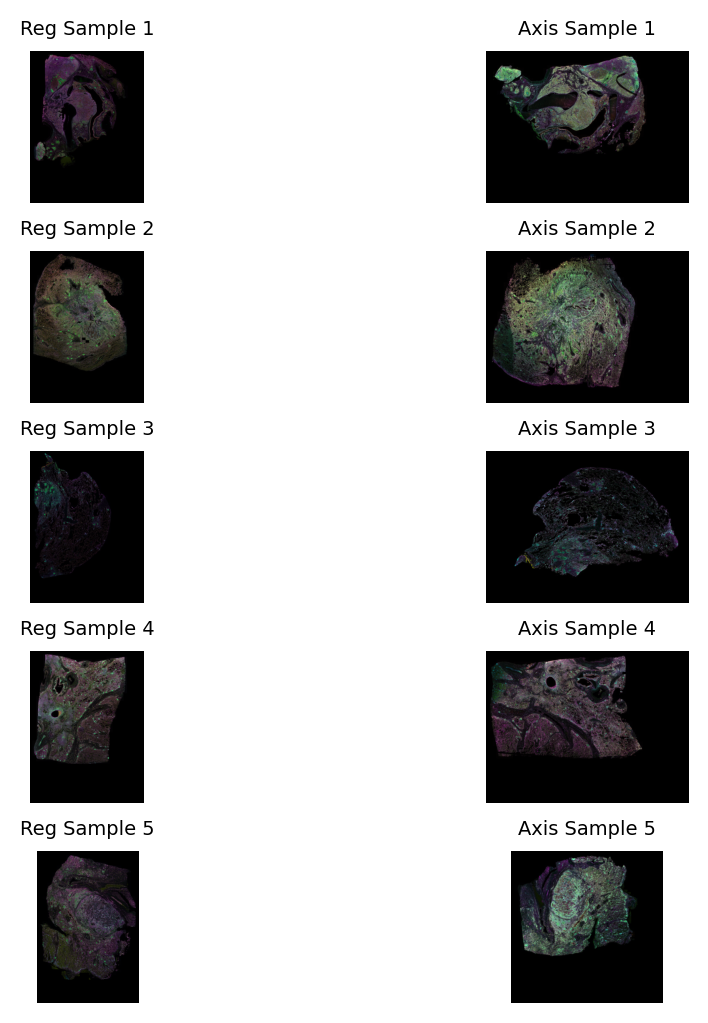

In [99]:
# Plot the first 5 images

pl.SubPlots(
    pl.ShowImage(sdata=sp, sampleid=results[0]['reg_sampleid'], title="Reg Sample 1"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[0]['axis_sampleid'], title="Axis Sample 1"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[1]['reg_sampleid'], title="Reg Sample 2"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[1]['axis_sampleid'], title="Axis Sample 2"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[2]['reg_sampleid'], title="Reg Sample 3"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[2]['axis_sampleid'], title="Axis Sample 3"),  # axis_sampleid
    
    pl.ShowImage(sdata=sp, sampleid=results[3]['reg_sampleid'], title="Reg Sample 4"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[3]['axis_sampleid'], title="Axis Sample 4"),  # axis_sampleid

    pl.ShowImage(sdata=sp, sampleid=results[4]['reg_sampleid'], title="Reg Sample 5"),  # reg_sampleid
    pl.ShowImage(sdata=sp, sampleid=results[4]['axis_sampleid'], title="Axis Sample 5"),  # axis_sampleid

   figsize=(5, 5),

)


## Rigid Registration (Scale 9)

### Load in spatial data 

In [106]:
# Loop through each image in sp.images and crop it
cropped_images = {}
for sampleid in sp.images:
    cropped_images[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=9)[0]

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times

panel = ['regression','axis']*46

panel_df = pd.DataFrame(panel, columns=['panel'])

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 times

panel = ['regression','axis']*46

panel_df = pd.DataFrame(panel, columns=['panel'])


#Save dimensions of the cropped images to a dataframe
cropped_images_dimensions = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_dimensions[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords
    }
#Convert to dataframe
cropped_images_dimensions_df = pd.DataFrame.from_dict(cropped_images_dimensions, orient='index')

#Add the panel column to the dataframe

cropped_images_dimensions_df['panel'] = panel_df['panel'].values

#View dimensions of the cropped images
cropped_images_dimensions_df

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_101_image,"(96, 128)",float32,"[c, y, x]",axis
sampleid_710_image,"(128, 96)",float32,"[c, y, x]",regression
sampleid_107_image,"(96, 128)",float32,"[c, y, x]",axis
sampleid_712_image,"(128, 96)",float32,"[c, y, x]",regression
...,...,...,...,...
sampleid_124_image,"(64, 96)",float32,"[c, y, x]",axis
sampleid_706_image,"(96, 96)",float32,"[c, y, x]",regression
sampleid_552_image,"(96, 96)",float32,"[c, y, x]",axis
sampleid_708_image,"(128, 96)",float32,"[c, y, x]",regression


In [ ]:
# Convert all images to numpy arrays

cropped_images_arrays = {}
for sampleid, cropped_image in cropped_images.items():
    cropped_images_arrays[sampleid] = cropped_image.compute()



In [108]:
# Convert all images to ants images
cropped_images_ants = {}
for sampleid, cropped_image in cropped_images_arrays.items():
    cropped_images_ants[sampleid] = ants.from_numpy(cropped_image)

cropped_images_ants

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_101_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_107_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (96, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 96)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_535_image': ANTsIma

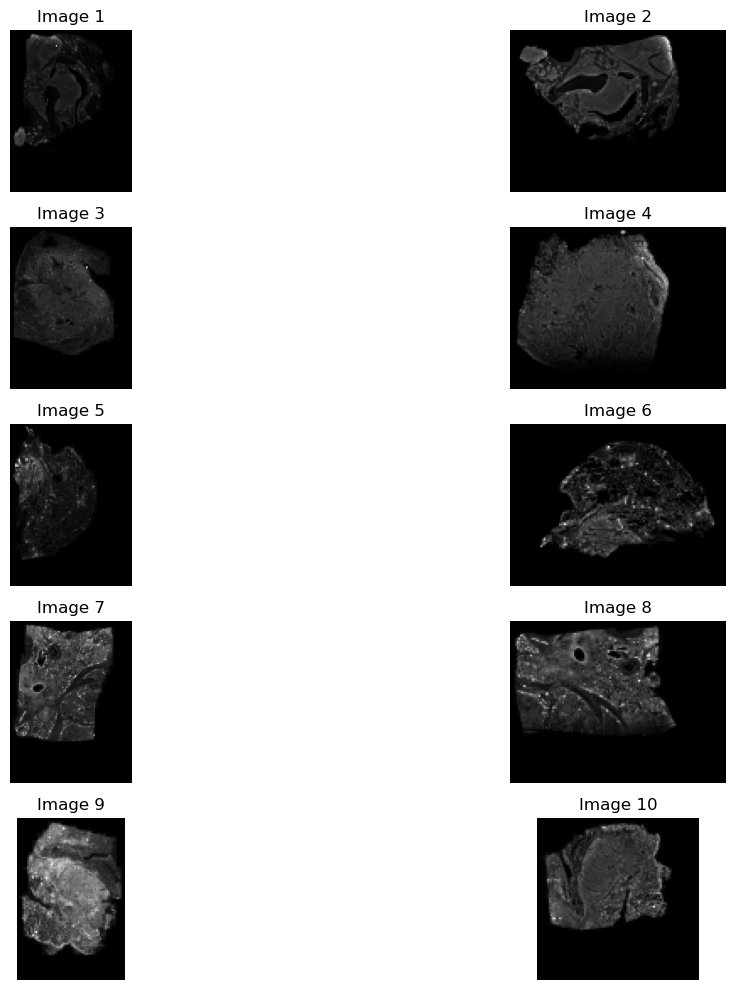

In [109]:
# Plot the first 10 images of cropped images using plt with 5 rows and 2 columns

fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, cropped_image) in enumerate(cropped_images_ants.items()):
    if i < 10:
        axes[i].imshow(cropped_image.numpy(), cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()



### Pad images

In [110]:
# Create a function to pad all images in cropped_images_ants to the same size

def pad_images_to_same_size(images):
    # Get the maximum dimensions
    max_shape = np.max([img.shape for img in images.values()], axis=0)

    # Pad each image to the maximum dimensions
    padded_images = {}
    for sampleid, img in images.items():
        pad_width = [(0, max_dim - img.shape[i]) for i, max_dim in enumerate(max_shape)]
        padded_images[sampleid] = np.pad(img.numpy(), pad_width, mode='constant', constant_values=0)
    return padded_images
# Pad the images
padded_images = pad_images_to_same_size(cropped_images_ants)

# Convert the padded images to ANTs images
padded_images_ants = {}
for sampleid, padded_image in padded_images.items():
    padded_images_ants[sampleid] = ants.from_numpy(padded_image)

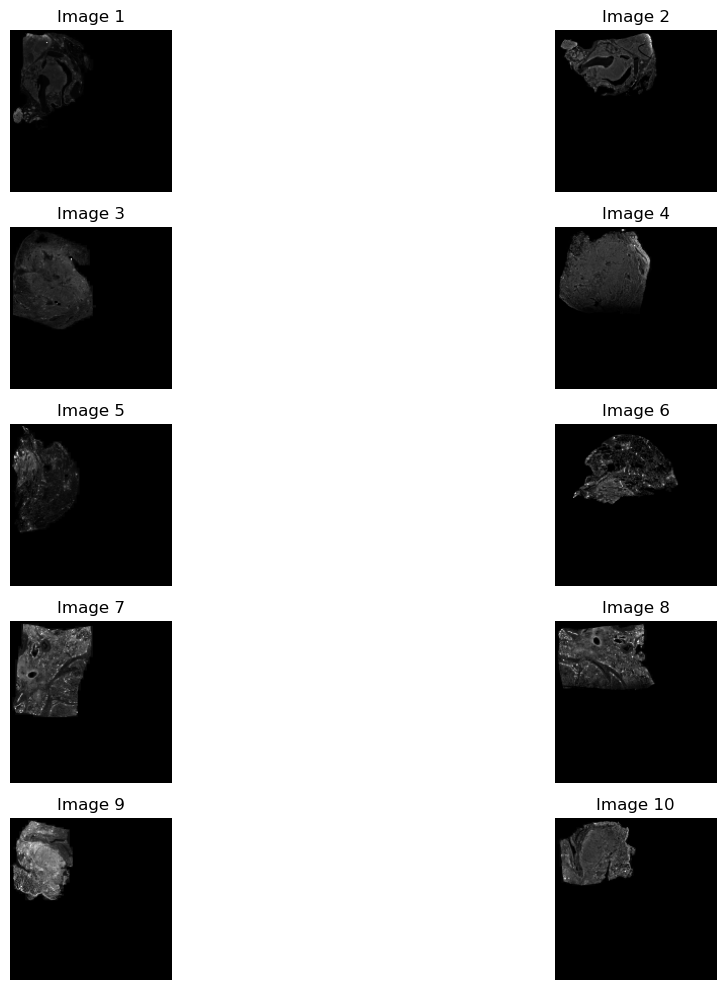

In [111]:
#Plot the first 10 images of padded images using plt with 5 rows and 2 columns
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i < 10:
        axes[i].imshow(padded_image.numpy(), cmap='gray')
        axes[i].set_title(f'Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

In [114]:
# Store odd and even images in separate lists: regression and tbet while keeping the key

# Create lists to store regression and tbet image
# images

regression_images = []
axis_images = []
for i, (sampleid, padded_image) in enumerate(padded_images_ants.items()):
    if i % 2 == 0:  # Even index
        regression_images.append((sampleid, padded_image))
    else:  # Odd index
        axis_images.append((sampleid, padded_image))

In [115]:
regression_images

[('sampleid_709_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_710_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_712_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_713_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_714_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

In [116]:
axis_images

[('sampleid_101_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_107_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_535_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_112_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Direction  : [1. 0. 0. 1.]),
 ('sampleid_114_image',
  ANTsImage
  	 Pixel Type : float (float32)
  	 Components : 1
  	 Dimensions : (160, 160)
  	 Spacing    : (1.0, 1.0)
  	 Origin     : (0.0, 0.0)
  	 Dire

### ANTS Rigid transform 

In [142]:
#Register the regression images to the axis image

registered_images = {}
for i, (reg_sampleid, reg_image) in enumerate(regression_images):
    # Get the corresponding axis image
    axis_sampleid, axis_image = axis_images[i]

    # Perform registration
    registered_image = ants.registration(fixed=reg_image, moving=axis_image, type_of_transform='Rigid',outprefix=f'C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/{reg_sampleid}_to_{axis_sampleid}_', verbose=True)

    # Store the registered image
    registered_images[reg_sampleid] = registered_image['warpedmovout']

    #Apply the transformation to the moving image
    transformed_image = ants.apply_transforms(fixed=reg_image, moving=axis_image, transformlist=registered_image['fwdtransforms'])



antsRegistration -d 2 -r [0000029B1E98BE48,0000029B1E98BDA8,1] -m mattes[0000029B1E98BE48,0000029B1E98BDA8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_709_image_to_sampleid_101_image_,0000029B1E98BD08,0000029B1E98B368] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B1E98B1A8,0000029B1E98B848,1] -m mattes[0000029B1E98B1A8,0000029B1E98B848,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Desktop/WSIFIR/scale_9_transform/axis_reg/sampleid_710_image_to_sampleid_107_image_,0000029B1E98B368,0000029B1E98BDA8] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r [0000029B1E98B1A8,0000029B1E98B848,1] -m mattes[0000029B1E98B1A8,0000029B1E98B848,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:/Users/molanre1/Deskt

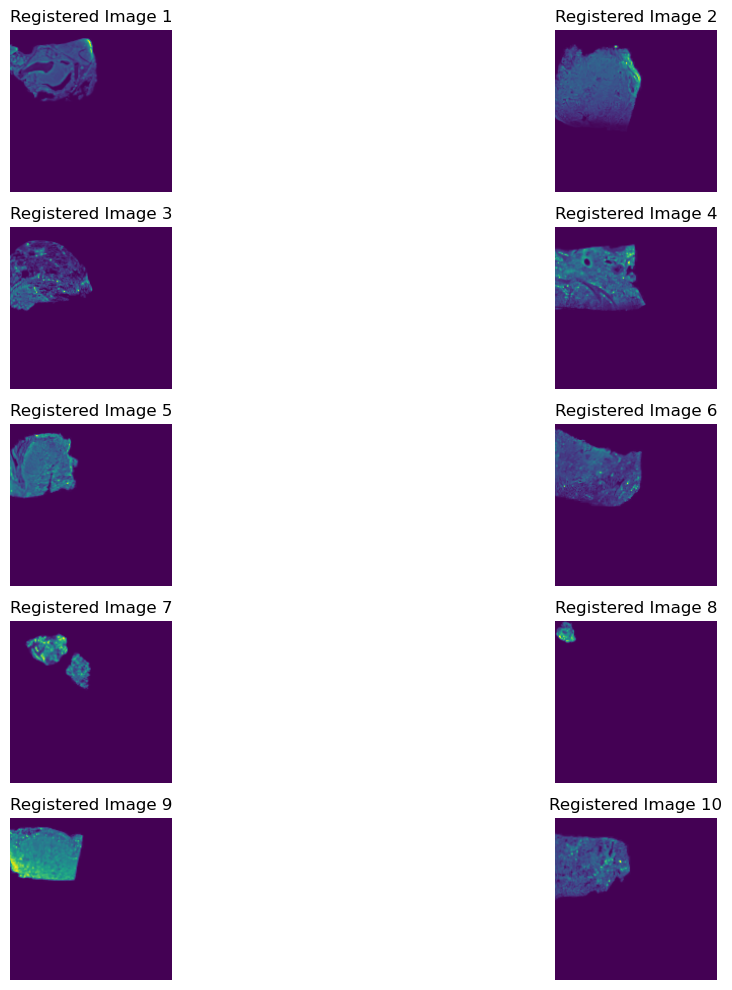

In [129]:
# Plot the first 10 registered images
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, registered_image) in enumerate(registered_images.items()):
    if i < 10:
        axes[i].imshow(registered_image.numpy())
        axes[i].set_title(f'Registered Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()

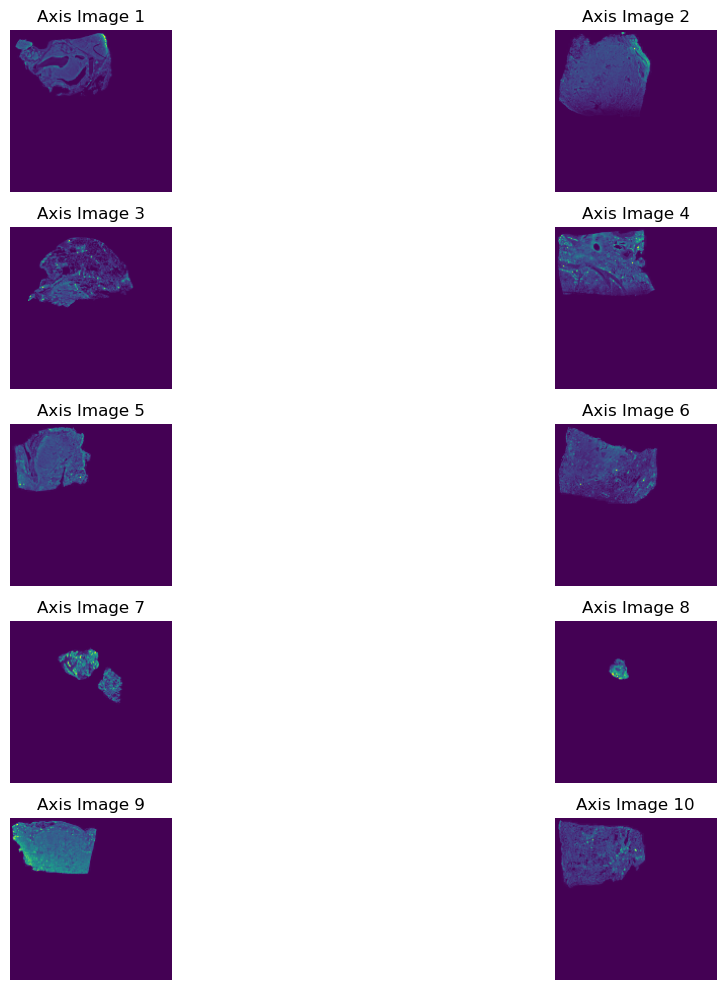

In [131]:
#Plot the first 10 axis images
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, axis_image) in enumerate(axis_images):
    if i < 10:
        axes[i].imshow(axis_image.numpy())
        axes[i].set_title(f'Axis Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()


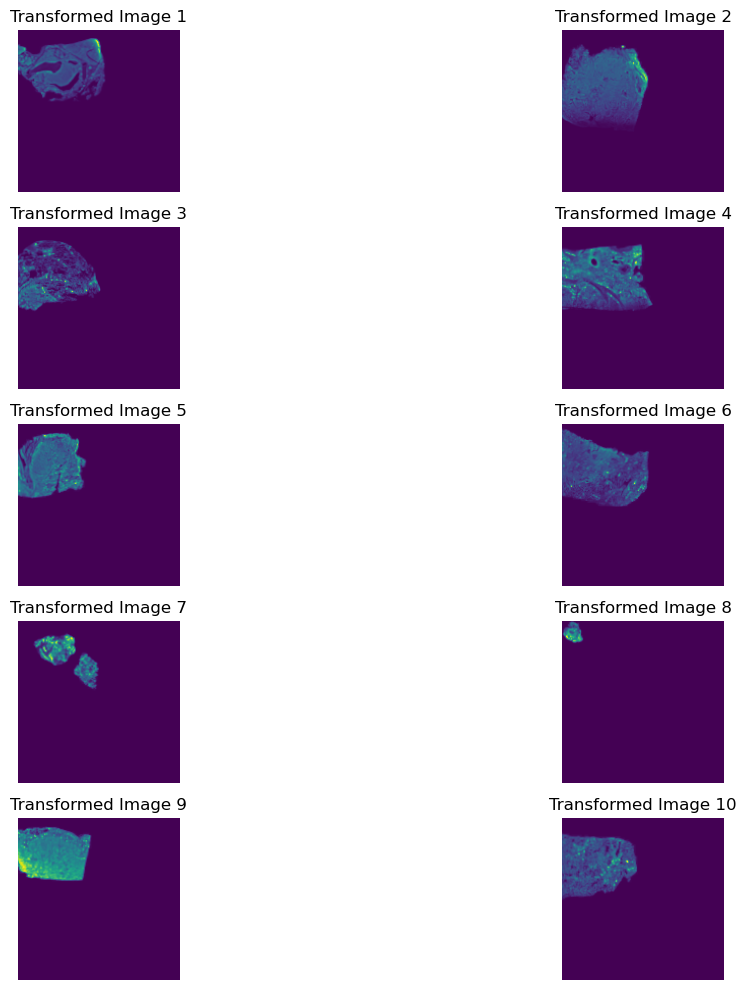

In [130]:
#Plot the first 10 registered images
fig, axes = plt.subplots(5, 2, figsize=(15, 10))
axes = axes.flatten()
for i, (sampleid, transformed_image) in enumerate(registered_images.items()):
    if i < 10:
        axes[i].imshow(transformed_image.numpy())
        axes[i].set_title(f'Transformed Image {i+1}')
        axes[i].axis('off')
plt.tight_layout()
plt.show()


In [141]:
registered_images

{'sampleid_709_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (160, 160)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_710_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (160, 160)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_712_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (160, 160)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_713_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (160, 160)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_714_image': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (160, 160)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'sampleid_715_image': AN

In [45]:
fwd_aff_1 = ants.read_transform(rigid_result_1_res_9['fwdtransforms'][0])
fwd_aff_1_parameters_np = np.array(fwd_aff_1.parameters)
fwd_aff_1_parameters_np

array([  0.92481023,  -0.39548534,   0.39878112,   0.90559542,
        19.87726021, -16.85927582])

In [46]:
fwd_aff_1.fixed_parameters


array([35.21538925, 41.98567581])

In [47]:
rigid_result_1_res_9

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_9_image1_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_9_image1_0GenericAffine.mat']}

In [48]:
fwd_aff_2 = ants.read_transform(rigid_result_2_res_9['fwdtransforms'][0])
fwd_aff_2_parameters_np = np.array(fwd_aff_2.parameters)
fwd_aff_2_parameters_np

array([  0.99479675,   0.12696075,  -0.12985094,   0.98358238,
        12.28430367, -12.82875824])

In [49]:
fwd_aff_2.fixed_parameters

array([42.12069702, 52.7854805 ])

In [50]:
rigid_result_3_res_9

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (128, 128)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration__scale_9_image3_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration__scale_9_image3_0GenericAffine.mat']}

In [51]:
fwd_aff_3 = ants.read_transform(rigid_result_3_res_9['fwdtransforms'][0])
fwd_aff_3_parameters_np = np.array(fwd_aff_3.parameters)
fwd_aff_3_parameters_np


array([ 0.93626189, -0.36535728,  0.36345997,  0.92660505, 42.76787949,
       -8.53610229])

In [52]:
fwd_aff_3.fixed_parameters

array([28.47519302, 50.77205276])

### Metrics

In [55]:
#Compute mutual information between the fixed regression and  transformed image pre/post registration
mi1_pre = ants.image_mutual_information(reg_image_cropped_ants_1_padded, axis_image_cropped_ants_1_padded)
mi2_pre = ants.image_mutual_information(reg_image_cropped_ants_2_padded, axis_image_cropped_ants_2_padded)
mi3_pre = ants.image_mutual_information(reg_image_cropped_ants_3_padded, axis_image_cropped_ants_3_padded)

mi1_post = ants.image_mutual_information(reg_image_cropped_ants_1_padded, rigid_transformed_image_1_res_9) 
mi2_post = ants.image_mutual_information(reg_image_cropped_ants_2_padded, rigid_transformed_image_2_res_9)   
mi3_post = ants.image_mutual_information(reg_image_cropped_ants_3_padded, rigid_transformed_image_3_res_9)


#Compute normalized cross correlation between the fixed regression and  transformed image pre registration
cc1_pre = ants.math.image_similarity(reg_image_cropped_ants_1_padded, axis_image_cropped_ants_1_padded, 'Correlation')
cc2_pre = ants.math.image_similarity(reg_image_cropped_ants_2_padded, axis_image_cropped_ants_2_padded, 'Correlation')
cc3_pre = ants.math.image_similarity(reg_image_cropped_ants_3_padded, axis_image_cropped_ants_3_padded, 'Correlation')

cc1_post = ants.math.image_similarity(reg_image_cropped_ants_1_padded,rigid_transformed_image_1_res_9, 'Correlation')
cc2_post = ants.math.image_similarity(reg_image_cropped_ants_2_padded, rigid_transformed_image_2_res_9, 'Correlation')
cc3_post  = ants.math.image_similarity(reg_image_cropped_ants_3_padded, rigid_transformed_image_3_res_9, 'Correlation')

#Compute mean squares between the fixed regression and  transformed image reg-tbet registration
mse1_pre = ants.math.image_similarity(reg_image_cropped_ants_1_padded,axis_image_cropped_ants_1_padded, 'MeanSquares')
mse2_pre = ants.math.image_similarity(reg_image_cropped_ants_2_padded, axis_image_cropped_ants_2_padded, 'MeanSquares')
mse3_pre = ants.math.image_similarity(reg_image_cropped_ants_3_padded, axis_image_cropped_ants_3_padded, 'MeanSquares')

mse1_post = ants.math.image_similarity(reg_image_cropped_ants_1_padded,rigid_transformed_image_1_res_9, 'MeanSquares')
mse2_post = ants.math.image_similarity(reg_image_cropped_ants_2_padded, rigid_transformed_image_2_res_9, 'MeanSquares')
mse3_post = ants.math.image_similarity(reg_image_cropped_ants_3_padded, rigid_transformed_image_3_res_9, 'MeanSquares')


In [58]:
# Binarize the arrays (threshold = 0.5) to create binary masks
reg_image_1_binary = (reg_image_cropped_ants_1_padded.numpy() > 0.5).astype(int)
reg_image_2_binary = (reg_image_cropped_ants_2_padded.numpy() > 0.5).astype(int)
reg_image_3_binary = (reg_image_cropped_ants_3_padded.numpy() > 0.5).astype(int)

axis_image_1_binary = (axis_image_cropped_ants_1_padded.numpy() > 0.5).astype(int)
axis_image_2_binary = (axis_image_cropped_ants_2_padded.numpy() > 0.5).astype(int)
axis_image_3_binary = (axis_image_cropped_ants_3_padded.numpy() > 0.5).astype(int)

rigid_result_1_binary = (rigid_transformed_image_1_res_9.numpy() > 0.5).astype(int)
rigid_result_2_binary = (rigid_transformed_image_2_res_9.numpy() > 0.5).astype(int)
rigid_result_3_binary = (rigid_transformed_image_3_res_9.numpy() > 0.5).astype(int)


In [60]:
# Compute Jaccard Index pre/post registration
jaccard_1_pre = jaccard_score(reg_image_1_binary.flatten(), axis_image_1_binary.flatten())
jaccard_2_pre = jaccard_score(reg_image_2_binary.flatten(), axis_image_2_binary.flatten())
jaccard_3_pre = jaccard_score(reg_image_3_binary.flatten(), axis_image_3_binary.flatten())

jaccard_1_post = jaccard_score(reg_image_1_binary.flatten(), rigid_result_1_binary.flatten())
jaccard_2_post = jaccard_score(reg_image_2_binary.flatten(), rigid_result_2_binary.flatten())
jaccard_3_post = jaccard_score(reg_image_3_binary.flatten(), rigid_result_3_binary.flatten())

# Compute Dice Similarity Score
dice1_pre = f1_score(reg_image_1_binary.flatten(), axis_image_1_binary.flatten())
dice2_pre = f1_score(reg_image_2_binary.flatten(), axis_image_2_binary.flatten())
dice3_pre = f1_score(reg_image_3_binary.flatten(), axis_image_3_binary.flatten())

dice1_post = f1_score(reg_image_1_binary.flatten(), rigid_result_1_binary.flatten())
dice2_post = f1_score(reg_image_2_binary.flatten(), rigid_result_2_binary.flatten())
dice3_post = f1_score(reg_image_3_binary.flatten(), rigid_result_3_binary.flatten())


In [62]:
# Convert the images to SimpleITK format

sitk_fixed_image_1 = sitk.GetImageFromArray(reg_image_cropped_ants_1_padded.numpy())
sitk_moving_image_1 = sitk.GetImageFromArray(axis_image_cropped_ants_1_padded.numpy())  
sitk_final_image_1 = sitk.GetImageFromArray(rigid_transformed_image_1_res_9.numpy())

sitk_fixed_image_2 = sitk.GetImageFromArray(reg_image_cropped_ants_2_padded.numpy())
sitk_moving_image_2 = sitk.GetImageFromArray(axis_image_cropped_ants_2_padded.numpy())
sitk_final_image_2 = sitk.GetImageFromArray(rigid_transformed_image_2_res_9.numpy())

sitk_fixed_image_3 = sitk.GetImageFromArray(reg_image_cropped_ants_3_padded.numpy())
sitk_moving_image_3 = sitk.GetImageFromArray(axis_image_cropped_ants_3_padded.numpy())
sitk_final_image_3 = sitk.GetImageFromArray(rigid_transformed_image_3_res_9.numpy())

# Compute Hausdorff Distance using SimpleITK pre/post registration
hausdorff_filter_1_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_1_pre.Execute(sitk_fixed_image_1, sitk_moving_image_1)
hausdorff_sitk_1_pre = hausdorff_filter_1_pre.GetHausdorffDistance()

hausdorff_filter_1_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_1_post.Execute(sitk_fixed_image_1, sitk_final_image_1)
hausdorff_sitk_1_post = hausdorff_filter_1_post.GetHausdorffDistance()

hausdorff_filter_2_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_2_pre.Execute(sitk_fixed_image_2, sitk_moving_image_2)
hausdorff_sitk_2_pre = hausdorff_filter_2_pre.GetHausdorffDistance()

hausdorff_filter_2_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_2_post.Execute(sitk_fixed_image_2, sitk_final_image_2)
hausdorff_sitk_2_post = hausdorff_filter_2_post.GetHausdorffDistance()

hausdorff_filter_3_pre = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_3_pre.Execute(sitk_fixed_image_3, sitk_moving_image_3)
hausdorff_sitk_3_pre = hausdorff_filter_3_pre.GetHausdorffDistance()

hausdorff_filter_3_post = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_3_post.Execute(sitk_fixed_image_3, sitk_final_image_3)
hausdorff_sitk_3_post = hausdorff_filter_3_post.GetHausdorffDistance()

In [63]:
#Display the mi pre and post registration

#Display the mi, cc, mse, jaccard, dice and hausdorff distance as bar graphs
metrics_df = pd.DataFrame({
    'Sample': ['Reg-Tbet Image 1', 'Reg-Tbet Image 2', 'Reg-Tbet Image 3'],
    'MI_pre': [mi1_pre, mi2_pre, mi3_pre],
    'MI_post': [mi1_post, mi2_post, mi3_post],
    'CC_pre': [cc1_pre, cc2_pre, cc3_pre],
    'CC_post': [cc1_post, cc2_post, cc3_post],
    'MSE_pre': [mse1_pre, mse2_pre, mse3_pre],
    'MSE_post': [mse1_post, mse2_post, mse3_post],
    'Jaccard_pre': [jaccard_1_pre, jaccard_2_pre, jaccard_3_pre],
    'Jaccard_post': [jaccard_1_post, jaccard_2_post, jaccard_3_post],
    'Dice_pre': [dice1_pre, dice2_pre, dice3_pre],
    'Dice_post': [dice1_post, dice2_post, dice3_post],
    'Hausdorff_pre': [hausdorff_sitk_1_pre, hausdorff_sitk_2_pre, hausdorff_sitk_3_pre],
    'Hausdorff_post': [hausdorff_sitk_1_post, hausdorff_sitk_2_post, hausdorff_sitk_3_post]
})

metrics_df

,Sample,MI_pre,MI_post,CC_pre,CC_post,MSE_pre,MSE_post,Jaccard_pre,Jaccard_post,Dice_pre,Dice_post,Hausdorff_pre,Hausdorff_post
0,Reg-Tbet Image 1,-0.060823,-0.120060,-0.065702,-0.132306,4.284006,3.381535,0.383166,0.521029,0.554042,0.685101,44.407207,25.942244
1,Reg-Tbet Image 2,-0.262018,-0.423323,-0.273343,-0.519161,1.672265,1.048654,0.620534,0.778749,0.765839,0.875614,17.464249,14.866069
2,Reg-Tbet Image 3,-0.034573,-0.222955,-0.009316,-0.236737,2.903595,1.619132,0.236285,0.609495,0.382250,0.757374,53.000000,18.788294


In [64]:
#Compute the magnitude of the pre and post registration differences

# Compute the differences
metrics_df['MI_diff'] = metrics_df['MI_post'] - metrics_df['MI_pre']
metrics_df['CC_diff'] = metrics_df['CC_post'] - metrics_df['CC_pre']
metrics_df['MSE_diff'] = metrics_df['MSE_post'] - metrics_df['MSE_pre']
metrics_df['Jaccard_diff'] = metrics_df['Jaccard_post'] - metrics_df['Jaccard_pre']
metrics_df['Dice_diff'] = metrics_df['Dice_post'] - metrics_df['Dice_pre']
metrics_df['Hausdorff_diff'] = metrics_df['Hausdorff_post'] - metrics_df['Hausdorff_pre']
# Convert the differences for only MI and CC to absolute values
metrics_df['MI_diff'] = np.abs(metrics_df['MI_diff'])
metrics_df['CC_diff'] = np.abs(metrics_df['CC_diff'])

#Display the differences
metrics_diff_df = metrics_df[['Sample', 'MI_diff', 'CC_diff', 'MSE_diff', 'Jaccard_diff', 'Dice_diff', 'Hausdorff_diff']]


#Display the differences
metrics_diff_df

,Sample,MI_diff,CC_diff,MSE_diff,Jaccard_diff,Dice_diff,Hausdorff_diff
0,Reg-Tbet Image 1,0.059238,0.066604,-0.902471,0.137862,0.131058,-18.464963
1,Reg-Tbet Image 2,0.161305,0.245819,-0.623610,0.158215,0.109775,-2.598180
2,Reg-Tbet Image 3,0.188382,0.227421,-1.284463,0.373210,0.375124,-34.211706


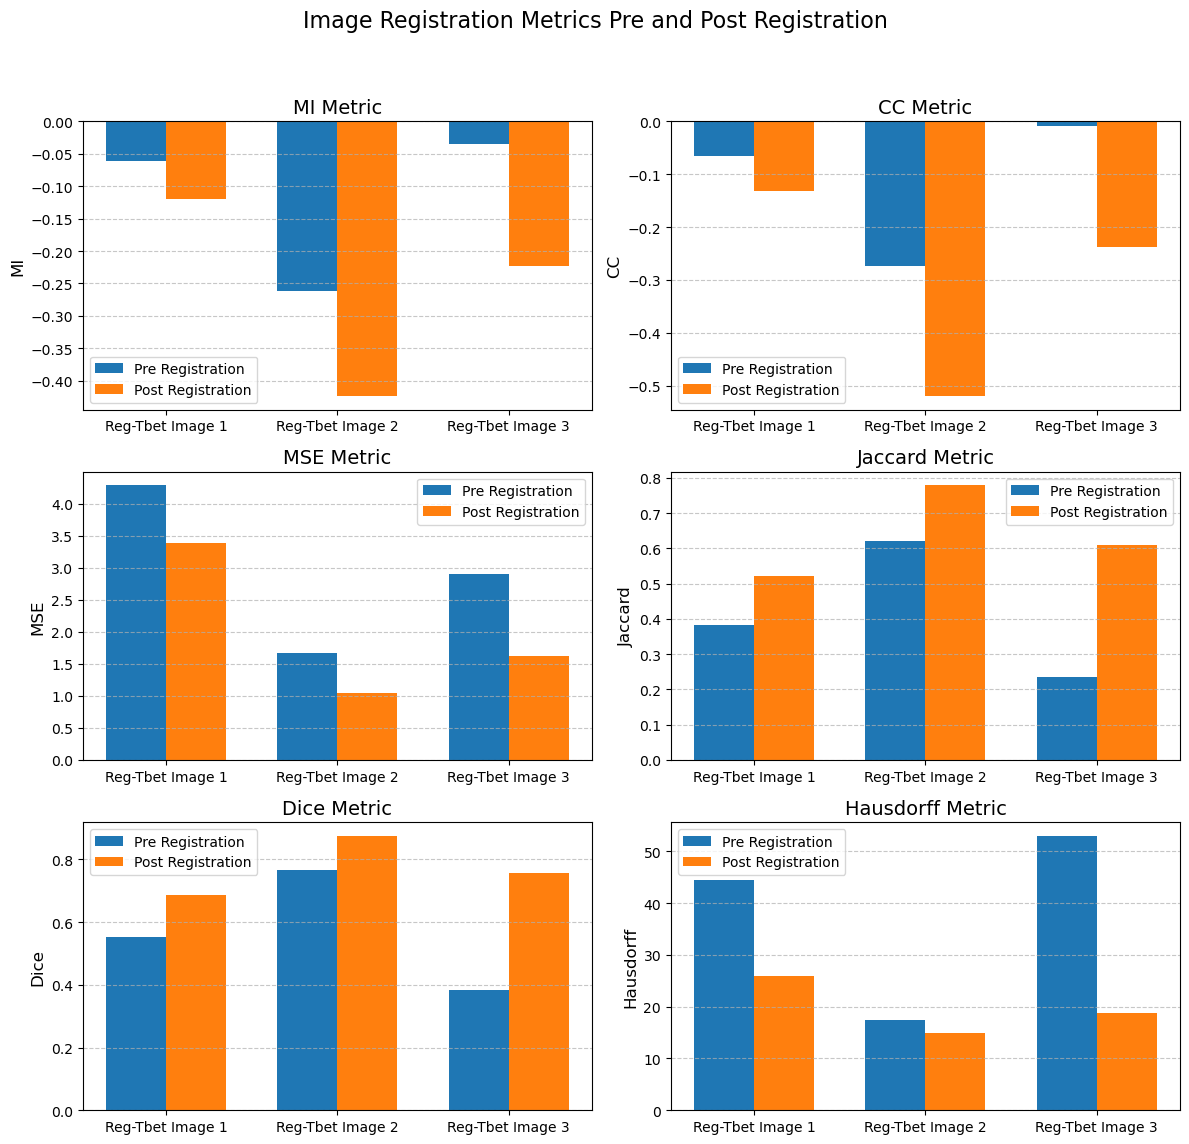

In [65]:
#Create a separate graph for each metric. Each graph should have 2 bars, one for pre registration and one for post registration
# Create a figure with subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 12))
# Set the figure title
fig.suptitle('Image Registration Metrics Pre and Post Registration', fontsize=16)
# Set the bar width
bar_width = 0.35
# Set the bar positions
bar_positions = np.arange(len(metrics_df['Sample']))
# Set the colors for the bars
colors = ['#1f77b4', '#ff7f0e']  # Blue and Orange
# Set the bar labels
bar_labels = ['Pre Registration', 'Post Registration']
# Set the metrics to plot
metrics_to_plot = ['MI', 'CC', 'MSE', 'Jaccard', 'Dice', 'Hausdorff']
# Loop through each metric and create a bar plot

for i, metric in enumerate(metrics_to_plot):
    # Create a bar plot for the metric
    axes[i // 2, i % 2].bar(bar_positions - bar_width/2, metrics_df[f'{metric}_pre'], width=bar_width, label='Pre Registration', color=colors[0])
    axes[i // 2, i % 2].bar(bar_positions + bar_width/2, metrics_df[f'{metric}_post'], width=bar_width, label='Post Registration', color=colors[1])
    
    # Set the x-ticks and labels
    axes[i // 2, i % 2].set_xticks(bar_positions)
    axes[i // 2, i % 2].set_xticklabels(metrics_df['Sample'])
    
    # Set the title and labels
    axes[i // 2, i % 2].set_title(f'{metric} Metric', fontsize=14)
    axes[i // 2, i % 2].set_ylabel(metric, fontsize=12)
    axes[i // 2, i % 2].legend()
    # Set grid lines
    axes[i // 2, i % 2].grid(axis='y', linestyle='--', alpha=0.7)


# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [69]:
#Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels

#Each different row represents a different tissue
row_1 = ids.iloc[[0]].copy()
row_2 = ids.iloc[[1]].copy()
row_3 = ids.iloc[[2]].copy()
                              

# Concatenate the rows into a single DataFrame
merged_df = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame
merged_df['scale'] = [9,9,9]  
merged_df['final_image_parameters'] = [fwd_aff_1.parameters,fwd_aff_2.parameters,fwd_aff_3.parameters]  
merged_df['final_image_fixed_parameters'] = [fwd_aff_1.fixed_parameters,fwd_aff_2.fixed_parameters,fwd_aff_3.fixed_parameters] 
merged_df.drop(columns=['tbet_sampleid'], inplace=True) 
merged_df.rename(columns={'sampleid': 'axis_sampleid', 'slideid': 'axis_slideid'}, inplace=True)
merged_df

,axis_sampleid,reg_sampleid,axis_slideid,reg_slideid,tbet_slideid,scale,final_image_parameters,final_image_fixed_parameters
0,101,709.0,L1_2,LY1,AP0140001,9,"[0.9248102307319641, -0.3954853415489197, 0.39...","[35.215389251708984, 41.98567581176758]"
1,107,710.0,L2_4,LY2,AP0140002,9,"[0.9947967529296875, 0.12696075439453125, -0.1...","[42.120697021484375, 52.78548049926758]"
2,535,712.0,L4_3,LY4,AP0140004,9,"[0.9362618923187256, -0.36535727977752686, 0.3...","[28.47519302368164, 50.77205276489258]"


In [70]:
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_9.csv', index=False)

## Regression to Axis Rigid Regression (Scale 7)

In [75]:
# Loop through each image in sp.images and crop it
cropped_images_2 = {}
for sampleid in sp.images:
    cropped_images_2[sampleid] = tl.crop_xarray_image(sp.images[sampleid], scale=7)[0]

#Create a dataframe with a columnn named panel that loops either axis, regression and tbet 3 time

panel = ['axis','regression']*3

panel_df = pd.DataFrame(panel, columns=['panel'])

#Save dimensions of the cropped images to a dataframe


cropped_images_dimensions_2 = {}
for sampleid, cropped_image in cropped_images_2.items():
    cropped_images_dimensions_2[sampleid] = {
        'dimensions': cropped_image.shape,
        'data_type': cropped_image.dtype,
        'coordinates': cropped_image.coords,
    }


#Convert to dataframe
cropped_images_dimensions_df_2 = pd.DataFrame.from_dict(cropped_images_dimensions_2, orient='index')


#Add the panel column to the cropped images dimensions dataframe

cropped_images_dimensions_df_2['panel'] = panel_df['panel'].values


cropped_images_dimensions_df_2

,dimensions,data_type,coordinates,panel
sampleid_709_image,"(512, 384)",float32,"[c, y, x]",axis
sampleid_101_image,"(384, 512)",float32,"[c, y, x]",regression
sampleid_710_image,"(512, 384)",float32,"[c, y, x]",axis
sampleid_107_image,"(384, 512)",float32,"[c, y, x]",regression
sampleid_712_image,"(512, 384)",float32,"[c, y, x]",axis
sampleid_535_image,"(384, 512)",float32,"[c, y, x]",regression


In [76]:
#Convert the cropped images to ants
axis_image_cropped_ants_4 = ants.from_numpy(cropped_images_2[f'sampleid_{results[0]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_4 = ants.from_numpy(cropped_images_2[f'sampleid_{results[0]["reg_sampleid"]}_image'].compute().data)

axis_image_cropped_ants_5 = ants.from_numpy(cropped_images_2[f'sampleid_{results[1]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_5 = ants.from_numpy(cropped_images_2[f'sampleid_{results[1]["reg_sampleid"]}_image'].compute().data)

axis_image_cropped_ants_6 = ants.from_numpy(cropped_images_2[f'sampleid_{results[2]["axis_sampleid"]}_image'].compute().data)
reg_image_cropped_ants_6 = ants.from_numpy(cropped_images_2[f'sampleid_{results[2]["reg_sampleid"]}_image'].compute().data)


In [77]:
#Pad the images so they are the same size
reg_image_cropped_shape_4 = reg_image_cropped_ants_4.shape
axis_image_cropped_shape_4= axis_image_cropped_ants_4.shape

reg_image_cropped_shape_5 = reg_image_cropped_ants_5.shape
axis_image_cropped_shape_5= axis_image_cropped_ants_5.shape

reg_image_cropped_shape_6 = reg_image_cropped_ants_6.shape
axis_image_cropped_shape_6= axis_image_cropped_ants_6.shape

#Get the target shapes for padding
target_shape_4_x = max(reg_image_cropped_shape_4[0],axis_image_cropped_shape_4[0])
target_shape_4_y = max(reg_image_cropped_shape_4[1],axis_image_cropped_shape_4[1])

target_shape_5_x = max(reg_image_cropped_shape_5[0],axis_image_cropped_shape_5[0])
target_shape_5_y = max(reg_image_cropped_shape_5[1],axis_image_cropped_shape_5[1])

target_shape_6_x = max(reg_image_cropped_shape_6[0],axis_image_cropped_shape_6[0])
target_shape_6_y = max(reg_image_cropped_shape_6[1],axis_image_cropped_shape_6[1])


#Calculate the padding
pad_reg_X_4 = (0,target_shape_4_x-reg_image_cropped_shape_4[0])
pad_reg_Y_4 = (0,target_shape_4_y-reg_image_cropped_shape_4[1])
pad_reg_X_5 = (0,target_shape_5_x-reg_image_cropped_shape_5[0])
pad_reg_Y_5 = (0,target_shape_5_y-reg_image_cropped_shape_5[1])
pad_reg_X_6 = (0,target_shape_6_x-reg_image_cropped_shape_6[0])
pad_reg_Y_6 = (0,target_shape_6_y-reg_image_cropped_shape_6[1])

# Pad the cropped images to match the size of the rigid transformed images
reg_image_cropped_ants_4_padded = ants.pad_image(reg_image_cropped_ants_4, (target_shape_4_x,target_shape_4_y))
reg_image_cropped_ants_5_padded = ants.pad_image(reg_image_cropped_ants_5, (target_shape_5_x,target_shape_5_y))
reg_image_cropped_ants_6_padded = ants.pad_image(reg_image_cropped_ants_6, (target_shape_6_x,target_shape_6_y))

# Pad the axis images to match the size of the rigid transformed images
axis_image_cropped_ants_4_padded = ants.pad_image(axis_image_cropped_ants_4, (target_shape_4_x,target_shape_4_y))
axis_image_cropped_ants_5_padded = ants.pad_image(axis_image_cropped_ants_5, (target_shape_5_x,target_shape_5_y))
axis_image_cropped_ants_6_padded = ants.pad_image(axis_image_cropped_ants_6, (target_shape_6_x,target_shape_6_y))

# Print the shapes of the padded images
print("Padded axis image shape 4: ", axis_image_cropped_ants_4_padded.shape)
print("Padded axis image shape 5: ", axis_image_cropped_ants_5_padded.shape)
print("Padded axis image shape 6: ", axis_image_cropped_ants_6_padded.shape,"\n")

print("Padded regression image shape 4: ", reg_image_cropped_ants_4_padded.shape)
print("Padded regression image shape 5: ", reg_image_cropped_ants_5_padded.shape)
print("Padded regression image shape 6: ", reg_image_cropped_ants_6_padded.shape,"\n")








Padded axis image shape 4:  (512, 512)
Padded axis image shape 5:  (512, 512)
Padded axis image shape 6:  (512, 512) 

Padded regression image shape 4:  (512, 512)
Padded regression image shape 5:  (512, 512)
Padded regression image shape 6:  (512, 512) 



In [84]:
def compute_scaling_factor(higher_res_scale, lower_res_scale):
    """
    Compute the scaling factor based on the image transformations.
    """
    # Directly compute the scaling factor as a scalar
    return lower_res_scale / higher_res_scale

def scale_transform(transform_path, scaling_factors):
    """
    Scale a 2D affine transformation matrix while preserving rotation components.
    
    Parameters:
        transform_path (str): Path to the original transformation matrix (.mat file).
        scaling_factors (list or float): Scaling factors for translation components. 
                                         Can be a scalar or a list of 2 values for 2D transformations.
    
    Returns:
        str: Path to the scaled transformation matrix.
    """
    try:
        # Read the transformation matrix
        transform = ants.read_transform(transform_path)
        
        # Ensure the transform is 2D
        if transform.dimension != 2:
            raise ValueError("This function only supports 2D transformations.")
        
        # Extract the transformation parameters
        parameters = np.array(transform.parameters)  # Convert to a NumPy array for easier manipulation
        
        # Validate scaling_factors
        if isinstance(scaling_factors, (int, float)):  # If scalar, apply uniformly
            scaling_factors = [scaling_factors] * 2
        elif len(scaling_factors) != 2:
            raise ValueError("Scaling factors must be a scalar or a list of 2 values for 2D transformations.")
        
        # Scale only the translation components (last two parameters for tx, ty in 2D affine)
        scaled_parameters = parameters.copy()
        if len(parameters) >= 6:  # Ensure there are enough parameters for a 2D affine transform
            scaled_parameters[4:6] *= scaling_factors  # Scale translation components (tx, ty)
        else:
            raise ValueError("Transformation parameters do not have enough components to scale translation.")
        
        # Create a new transform with the scaled parameters
        scaled_transform = ants.create_ants_transform(
            transform_type=transform.type,  # Use the same transform type
            dimension=transform.dimension,  # Use the same dimension (2D)
            parameters=scaled_parameters.tolist(),  # Convert back to a list
            fixed_parameters=transform.fixed_parameters  # Keep the fixed parameters unchanged
        )
        
        # Save the scaled transformation matrix
        scaled_transform_path = transform_path.replace('.mat', '_scaled.mat')
        ants.write_transform(scaled_transform, scaled_transform_path)
        
        return scaled_transform_path
    
    except Exception as e:
        raise RuntimeError(f"Error scaling transform: {e}")

In [82]:
# Compute scaling factors for scale 7 and scale 9
scaling_factor_1 = compute_scaling_factor(sp.images[f'{reg_name_1}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_1}']['scale9'].image.transform['scale0'].scale[0])
scaling_factor_2 = compute_scaling_factor(sp.images[f'{reg_name_2}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_2}']['scale9'].image.transform['scale0'].scale[0])
scaling_factor_3 = compute_scaling_factor(sp.images[f'{reg_name_3}']['scale7'].image.transform['scale0'].scale[0], sp.images[f'{reg_name_3}']['scale9'].image.transform['scale0'].scale[0])

#Convert the scaling factors to be floats
scaling_factor_1 = float(scaling_factor_1)
scaling_factor_2 = float(scaling_factor_2)
scaling_factor_3 = float(scaling_factor_3)

In [85]:
scaled_transform_mat_1 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_9_image1_0GenericAffine.mat', # Path to the transform file
    scaling_factor_1
)

# Perform rigid registration first on the first image
rigid_result_1_res_7 = ants.registration(
    fixed=reg_image_cropped_ants_4_padded, #regression should be fixed
    moving=axis_image_cropped_ants_4_padded, #rigid_transformed_image should be moving
    initial_transform=scaled_transform_mat_1,
    type_of_transform='Rigid',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_7_image1_'
)

#Apply the rigid transformation to the first moving image
rigid_transformed_image_1_res_7 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_4_padded,
    moving=axis_image_cropped_ants_4_padded,
    transformlist=rigid_result_1_res_7['fwdtransforms']
)

# Apply the scaling factors to the transformations
scaled_transform_mat_2 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_9_image2_0GenericAffine.mat',  # Corrected path
    scaling_factor_2
)

# Perform rigid registration first on the second image
rigid_result_2_res_7 = ants.registration(
    fixed=reg_image_cropped_ants_5_padded,
    moving=axis_image_cropped_ants_5_padded,
    initial_transform=scaled_transform_mat_2,
    type_of_transform='Rigid',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_7_image2_'  # Descriptive outprefix
)

# Apply the rigid transformation to the second moving image
rigid_transformed_image_2_res_7 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_5_padded,
    moving=axis_image_cropped_ants_5_padded,
    transformlist=rigid_result_2_res_7['fwdtransforms']
)

# Apply the scaling factors to the transformations
scaled_transform_mat_3 = scale_transform(
    'C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration__scale_9_image3_0GenericAffine.mat',
    scaling_factor_3
)# Perform rigid registration first on the third image

rigid_result_3_res_7 = ants.registration(
    fixed=reg_image_cropped_ants_6_padded,
    moving=axis_image_cropped_ants_6_padded,
    initial_transform=scaled_transform_mat_3,
    type_of_transform='Rigid',
    aff_metric='Mattes',
    verbose=True,
    outprefix='C:\\Users\\molanre1\\Desktop\\WSIFIR\\axis_reg_rigid_registration_scale_7_image3_'
)

# Apply the rigid transformation to the third moving image
rigid_transformed_image_3_res_7 = ants.apply_transforms(
    fixed=reg_image_cropped_ants_6_padded,
    moving=axis_image_cropped_ants_6_padded,
    transformlist=rigid_result_3_res_7['fwdtransforms']
)

antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\axis_reg_rigid_registration_scale_9_image1_0GenericAffine_scaled.mat -m Mattes[0000029ABA968B08,0000029ABA969CA8,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\axis_reg_rigid_registration_scale_7_image1_,0000029ABA968868,0000029ABA969B88] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\axis_reg_rigid_registration_scale_9_image2_0GenericAffine_scaled.mat -m Mattes[0000029ABA968868,0000029ABA968B08,1,32,regular,0.2] -t Rigid[0.25] -c 2100x1200x1200x10 -s 3x2x1x0 -f 6x4x2x1 -u 1 -z 1 -o [C:\Users\molanre1\Desktop\WSIFIR\axis_reg_rigid_registration_scale_7_image2_,0000029ABA969988,0000029ABA968F08] -x [NA,NA] --float 1 --write-composite-transform 0 -v 1
antsRegistration -d 2 -r C:\Users\molanre1\Desktop\WSIFIR\axis_reg_rigid_registration__scale_9_image3_0GenericAffine_scaled.mat -m Mattes[0000

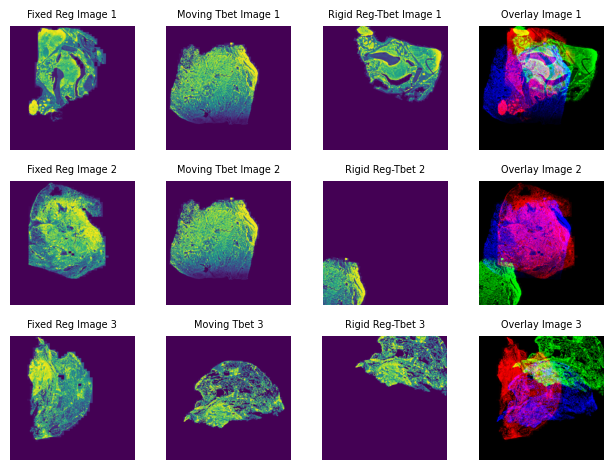

In [88]:
# Visualize the results
plt.subplot(3,4,1)
fixed_4 = exposure.equalize_hist(reg_image_cropped_ants_4_padded.numpy())
plt.imshow(fixed_4)
plt.title('Fixed Reg Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,2)
moving_4 = exposure.equalize_hist(axis_image_cropped_ants_5_padded.numpy())
plt.imshow(moving_4) 
plt.title('Moving Tbet Image 1',fontsize=7)
plt.axis('off')

plt.subplot(3,4,3)
registered_4 = exposure.equalize_hist(rigid_transformed_image_1_res_7.numpy())
plt.imshow(registered_4)
plt.title('Rigid Reg-Tbet Image 1',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_4_normalized = (fixed_4 - fixed_4.min()) / (fixed_4.max() - fixed_4.min())
registered_4_normalized = (registered_4 - registered_4.min()) / (registered_4.max() - registered_4.min())
moving_4_normalized = (moving_4 - moving_4.min()) / (moving_4.max() - moving_4.min())

#Overlay for the first image
plt.subplot(3, 4, 4)
overlay_4 = np.stack([fixed_4_normalized, registered_4_normalized, moving_4_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_4)
plt.title('Overlay Image 1', fontsize=7)
plt.axis('off')

plt.subplot(3,4,5)
fixed_5 = exposure.equalize_hist(reg_image_cropped_ants_5_padded.numpy())
plt.imshow(fixed_5)
plt.title('Fixed Reg Image 2',fontsize=7)
plt.axis('off')

plt.subplot(3,4,6)
moving_5 = exposure.equalize_hist(axis_image_cropped_ants_5_padded.numpy())
plt.imshow(moving_5)
plt.title('Moving Tbet Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,7)
registered_5 = exposure.equalize_hist(rigid_transformed_image_2_res_7.numpy())
plt.imshow(registered_5)
plt.title('Rigid Reg-Tbet 2',fontsize=7)
plt.axis('off')

# Normalize the images to [0, 1] for proper overlay visualization
fixed_5_normalized = (fixed_5 - fixed_5.min()) / (fixed_5.max() - fixed_5.min())
registered_5_normalized = (registered_5 - registered_5.min()) / (registered_5.max() - registered_5.min())
moving_5_normalized = (moving_5 - moving_5.min()) / (moving_5.max() - moving_5.min())

#Overlay for the second image
plt.subplot(3, 4, 8)
overlay_5 = np.stack([fixed_5_normalized, registered_5_normalized, moving_5_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_5)
plt.title('Overlay Image 2', fontsize=7)
plt.axis('off')

plt.subplot(3,4,9)
fixed_6 = exposure.equalize_hist(reg_image_cropped_ants_6_padded.numpy())
plt.imshow(fixed_6) 
plt.title('Fixed Reg Image 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,10)
moving_6 = exposure.equalize_hist(axis_image_cropped_ants_6_padded.numpy())
plt.imshow(moving_6)
plt.title('Moving Tbet 3',fontsize=7)
plt.axis('off')

plt.subplot(3,4,11)
registered_6 = exposure.equalize_hist(rigid_transformed_image_3_res_7.numpy())
plt.imshow(registered_6)
plt.title('Rigid Reg-Tbet 3',fontsize=7)
plt.axis('off')


# Normalize the images to [0, 1] for proper overlay visualization
fixed_6_normalized = (fixed_6 - fixed_6.min()) / (fixed_6.max() - fixed_6.min())
registered_6_normalized = (registered_6 - registered_6.min()) / (registered_6.max() - registered_6.min())
moving_6_normalized = (moving_6 - moving_6.min()) / (moving_6.max() - moving_6.min())

#Overlay for the third image
plt.subplot(3,4,12)
overlay_6 = np.stack([fixed_6_normalized, registered_6_normalized, moving_6_normalized], axis=-1)  # Red for fixed, Blue for moving. Green for registered
plt.imshow(overlay_6)
plt.title('Overlay Image 3', fontsize=7)
plt.axis('off')

plt.tight_layout()  
plt.show()


In [109]:
rigid_result_4 #This is the result of the rigid registration

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image4_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image4_0GenericAffine.mat']}

In [110]:
rigid_result_5

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image5_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image5_0GenericAffine.mat']}

In [111]:
rigid_result_6

{'warpedmovout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (0.0, -64.0)
 	 Direction  : [1. 0. 0. 1.],
 'warpedfixout': ANTsImage
 	 Pixel Type : float (float32)
 	 Components : 1
 	 Dimensions : (512, 512)
 	 Spacing    : (1.0, 1.0)
 	 Origin     : (-64.0, 0.0)
 	 Direction  : [1. 0. 0. 1.],
 'fwdtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image6_0GenericAffine.mat'],
 'invtransforms': ['C:\\Users\\molanre1\\Desktop\\WSIFIR\\rigid_registration_image6_0GenericAffine.mat']}

In [112]:
fwd_aff_4 = ants.read_transform(rigid_result_4['fwdtransforms'][0])
fwd_aff_4_parameters_np = np.array(fwd_aff_4.parameters)
fwd_aff_4_parameters_np

array([ 0.99822366,  0.05957771, -0.05957771,  0.99822366,  2.56856155,
       11.42338562])

In [113]:
fwd_aff_4.fixed_parameters

array([115.42973328, 218.6615448 ])

In [115]:
fwd_aff_5 = ants.read_transform(rigid_result_5['fwdtransforms'][0])
fwd_aff_5_parameters_np = np.array(fwd_aff_5.parameters)
fwd_aff_5_parameters_np

array([ 9.99992013e-01,  3.99612123e-03, -3.99612123e-03,  9.99992013e-01,
       -9.65154552e+00,  6.79183960e+00])

In [117]:
fwd_aff_5.fixed_parameters

array([168.8303833, 201.3110199])

In [118]:
fwd_aff_6 = ants.read_transform(rigid_result_6['fwdtransforms'][0])
fwd_aff_6_parameters_np = np.array(fwd_aff_6.parameters)
fwd_aff_6_parameters_np

array([ 9.99936044e-01, -1.13113541e-02,  1.13113541e-02,  9.99936044e-01,
       -5.42118025e+00,  4.09160614e+01])

In [119]:
fwd_aff_6.fixed_parameters

array([200.70407104, 225.44619751])

In [120]:
#Metrics

# Compute mutual information
mi4 = ants.image_mutual_information(rigid_transformed_image_4, rigid_result_4['warpedmovout'])
mi5 = ants.image_mutual_information(rigid_transformed_image_5, rigid_result_5['warpedmovout'])
mi6 = ants.image_mutual_information(rigid_transformed_image_6, rigid_result_6['warpedmovout'])

# Compute normalized cross-correlation
cc4 = ants.math.image_similarity(rigid_transformed_image_4,  rigid_result_4['warpedmovout'], 'Correlation')
cc5 = ants.math.image_similarity(rigid_transformed_image_5, rigid_result_5['warpedmovout'], 'Correlation')
cc6 = ants.math.image_similarity(rigid_transformed_image_6,  rigid_result_6['warpedmovout'], 'Correlation')

# Compute mean squares
mse4 = ants.math.image_similarity(rigid_transformed_image_4,  rigid_result_4['warpedmovout'], 'MeanSquares')
mse5 = ants.math.image_similarity(rigid_transformed_image_5,  rigid_result_5['warpedmovout'], 'MeanSquares')
mse6 = ants.math.image_similarity(rigid_transformed_image_6, rigid_result_6['warpedmovout'], 'MeanSquares')


In [139]:
# Binarize the arrays (threshold = 0.5)


rigid_transformed_image_4_binary = (rigid_transformed_image_4.numpy() > 0.5).astype(int)
rigid_transformed_image_5_binary = (rigid_transformed_image_5.numpy() > 0.5).astype(int)
rigid_transformed_image_6_binary = (rigid_transformed_image_6.numpy() > 0.5).astype(int)

rigid_result_4_binary = (rigid_result_4['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_5_binary = (rigid_result_5['warpedmovout'].numpy() > 0.5).astype(int)
rigid_result_6_binary = (rigid_result_6['warpedmovout'].numpy() > 0.5).astype(int)


# Compute Jaccard Index
jaccard_4 = jaccard_score(rigid_transformed_image_4_binary.flatten(), rigid_result_4_binary.flatten())
jaccard_5 = jaccard_score(rigid_transformed_image_5_binary.flatten(), rigid_result_5_binary.flatten())  
jaccard_6 = jaccard_score(rigid_transformed_image_6_binary.flatten(), rigid_result_6_binary.flatten())


# Compute Dice Similarity Score

dice4 = f1_score(rigid_transformed_image_4_binary.flatten(), rigid_result_4_binary.flatten())
dice5 = f1_score(rigid_transformed_image_5_binary.flatten(), rigid_result_5_binary.flatten())
dice6 = f1_score(rigid_transformed_image_6_binary.flatten(), rigid_result_6_binary.flatten())


# Compute Hausdorff Distance using SimpleITK
sitk_initial_image_4 = sitk.GetImageFromArray(rigid_transformed_image_4.numpy())
sitk_final_image_4 = sitk.GetImageFromArray(rigid_result_4['warpedmovout'].numpy())

sitk_initial_image_5 = sitk.GetImageFromArray(rigid_transformed_image_5.numpy())
sitk_final_image_5 = sitk.GetImageFromArray(rigid_result_5['warpedmovout'].numpy())

sitk_initial_image_6 = sitk.GetImageFromArray(rigid_transformed_image_6.numpy())
sitk_final_image_6 = sitk.GetImageFromArray(rigid_result_6['warpedmovout'].numpy())

# Compute Hausdorff Distance for axis image 1 and final image 1
hausdorff_filter_4 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_4.Execute(sitk_initial_image_4, sitk_final_image_4)
hausdorff_sitk_4 = hausdorff_filter_4.GetHausdorffDistance()

hausdorff_filter_5 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_5.Execute(sitk_initial_image_5, sitk_final_image_5)
hausdorff_sitk_5 = hausdorff_filter_5.GetHausdorffDistance()

hausdorff_filter_6 = sitk.HausdorffDistanceImageFilter()
hausdorff_filter_6.Execute(sitk_initial_image_6, sitk_final_image_6)
hausdorff_sitk_6 = hausdorff_filter_6.GetHausdorffDistance()



<Figure size 1000x600 with 0 Axes>

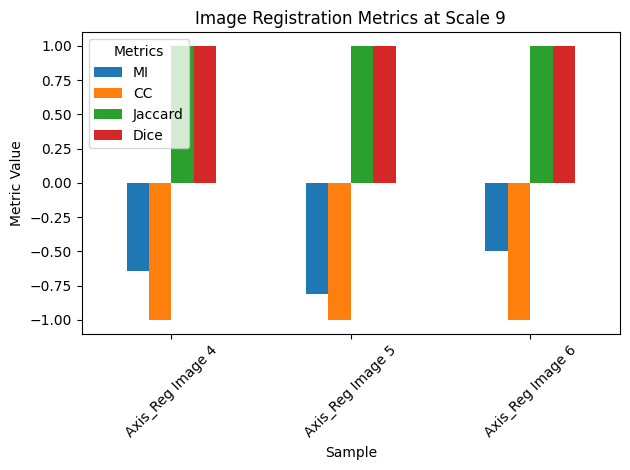

<Figure size 1000x600 with 0 Axes>

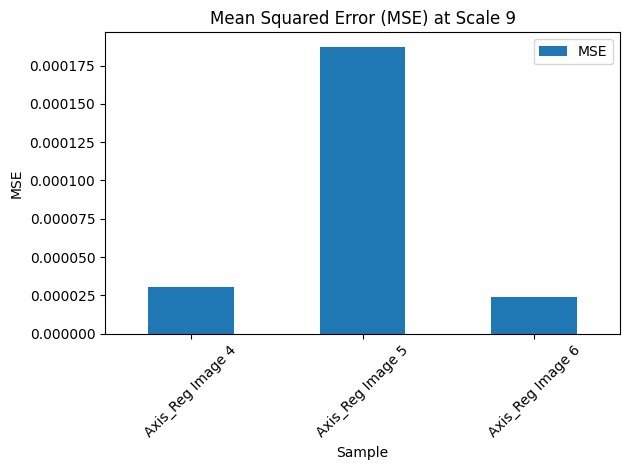

<Figure size 1000x600 with 0 Axes>

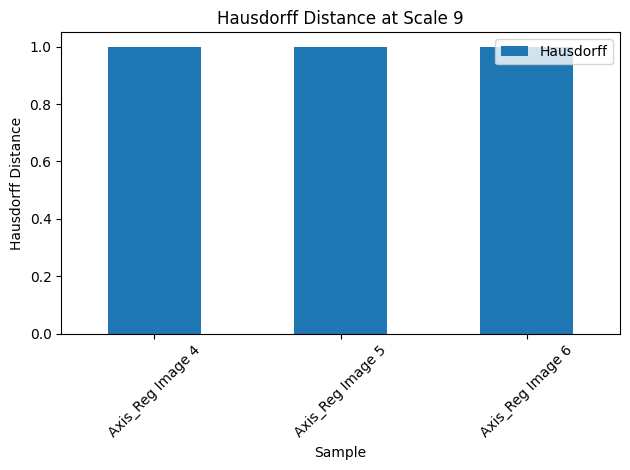

In [145]:
#Display the mi, cc, mse, jaccard, dice and hausdorff distance as graphs
metrics_df = pd.DataFrame({
    'Sample': ['Axis_Reg Image 4', 'Axis_Reg Image 5', 'Axis_Reg Image 6'],
    'MI': [mi4, mi5, mi6],
    'CC': [cc4, cc5, cc6],
    'MSE': [mse4, mse5, mse6],
    'Jaccard': [jaccard_4, jaccard_5, jaccard_6],
    'Dice': [dice4, dice5, dice6],
    'Hausdorff': [hausdorff_sitk_4, hausdorff_sitk_5, hausdorff_sitk_6]
})

# Set the index to the Sample ID
metrics_df.set_index('Sample', inplace=True)

# Plot the metrics minus hausdorff distance and mse
plt.figure(figsize=(10, 6))
metrics_df[['MI', 'CC', 'Jaccard', 'Dice']].plot(kind='bar')
plt.title('Image Registration Metrics at Scale 9')
plt.ylabel('Metric Value')
plt.xticks(rotation=45)
plt.legend(title='Metrics')
plt.tight_layout()
plt.show()

# Plot the Mean Squared Error (MSE)
plt.figure(figsize=(10, 6))
metrics_df[['MSE']].plot(kind='bar')
plt.title('Mean Squared Error (MSE) at Scale 9')
plt.ylabel('MSE')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


# Plot the Hausdorff distance
plt.figure(figsize=(10, 6))
metrics_df[['Hausdorff']].plot(kind='bar')
plt.title('Hausdorff Distance at Scale 9')
plt.ylabel('Hausdorff Distance')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [140]:
#Create dataframe to store the results

# Convert each set of corresponding tissue slices into a DataFrame
#Each row has the same tissue, but 3 different slices representing the same tissue stained with the axis, regression and tbet panels
#Each different row represents a different tissue

row_1 = pd.DataFrame([results[0]])
row_2 = pd.DataFrame([results[1]])
row_3 = pd.DataFrame([results[2]])
                              

# Concatenate the rows into a single DataFrame
merged_df_2 = pd.concat([row_1, row_2, row_3], ignore_index=True)

#Add columns to the merged DataFrame

merged_df_2['scale'] = [7,7,7]
merged_df_2['final_image_fixed_parameters'] = [fwd_aff_4.fixed_parameters,fwd_aff_5.fixed_parameters,fwd_aff_6.fixed_parameters] 
merged_df_2['final_image_parameters'] = [fwd_aff_4.parameters,fwd_aff_5.parameters,fwd_aff_6.parameters] 
merged_df_2['mi_reg_transformed_axis'] = [mi4,mi5,mi6]
merged_df_2['cc_reg_transformed_axis'] = [cc4,cc5,cc6]
merged_df_2['mse_reg_transformed_axis'] = [mse4,mse5,mse6]
merged_df_2['jaccard_reg_transformed_axis'] = [jaccard_4,jaccard_5,jaccard_6]
merged_df_2['dice_reg_transformed_axis'] = [dice4,dice5,dice6]
merged_df_2['hausdorff_reg_transformed_axis'] = [hausdorff_sitk_4,hausdorff_sitk_5,hausdorff_sitk_6]


  




In [141]:
merged_df_2

,axis_sampleid,reg_sampleid,tbet_sampleid,slideid,reg_slideid,tbet_slideid,scale,final_image_fixed_parameters,final_image_parameters,mi_reg_transformed_axis,cc_reg_transformed_axis,mse_reg_transformed_axis,jaccard_reg_transformed_axis,dice_reg_transformed_axis,hausdorff_reg_transformed_axis
0,101,709,834,L1_2,LY1,AP0140001,7,"[115.42973327636719, 218.6615447998047]","[0.9982236623764038, 0.059577714651823044, -0....",-0.640391,-0.999993,0.000031,0.999462,0.999731,1.0
1,107,710,835,L2_4,LY2,AP0140002,7,"[168.83038330078125, 201.31101989746094]","[0.9999920129776001, 0.003996121231466532, -0....",-0.811161,-0.999920,0.000187,0.998606,0.999303,1.0
2,535,712,837,L4_3,LY4,AP0140004,7,"[200.70407104492188, 225.44619750976562]","[0.999936044216156, -0.011311354115605354, 0.0...",-0.494623,-0.999992,0.000024,0.999123,0.999561,1.0


In [142]:
merged_df.to_csv('C:/Users/molanre1/Desktop/WSIFIR/xform_reg_to_axis_scale_7.csv', index=False)

In [ ]:
#One matrix should be zeros as it the one being registered to the other. 
#Two tables one for axis and one for tbet. Tbet to regression and axis to regression
#Rigid registration at resolutions 9 and 7 (one pipeline), then affine at 5 and 3 (2nd pipeline), then deformable at 1
#Show similarity metrics at each step 
#Similarity metrics from transformed axis to regression. Transformed tbet to regression. Transformed axis to tbet (could be to validate registration)
#Talk about different registration methods compared to ANTsPy (e.g., STAlign, Sckit-image) why ANTsPy was chosen.
#Focus on 2-3 sets of images for use case

In [ ]:
#Is there any need for coordinate registration with STAlign since the images have spatial data?
#Should I repeat the process for each of the resolutions for each indiividual image? 
#Save transformation matrix
# Need to find a way to register the images at each resolution level by taking the registration result from the previous level as the initial transformation for the next level



#Should I also repeat the process for the other images in the database? Can I pick a handful of images to register?
#https://github.com/ANTsX/ANTsPy/blob/master/tutorials/concatenateRegistrations.ipynb 
#https://github.com/AstroPathJHU/WSIMIR 

In [ ]:

#Sources:

# https://pmc.ncbi.nlm.nih.gov/articles/PMC7584382/

#https://pubmed.ncbi.nlm.nih.gov/38632390/ 

#https://www.nature.com/articles/s41598-021-87564-6 

#Multi-resolution registration:
#https://discourse.itk.org/t/multiresolution-registration-with-2d-affine-transformation-on-pairs-of-2d-images/3096/10